Import Libraries

In [363]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
from tqdm import tqdm

In [364]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [365]:
mSeed = 99
random.seed(mSeed)
torch.manual_seed(mSeed)
torch.use_deterministic_algorithms


<function torch.use_deterministic_algorithms(mode: bool, *, warn_only: bool = False) -> None>

In [366]:
import os
current_directory = os.getcwd()
main_directory = os.path.abspath(os.path.join(current_directory, "../.."))
print(main_directory)

f:\SunsetPredictor


Import Weather Data     

In [367]:
weather_data  = pd.read_csv(main_directory + "/src/weather/data/golden_co/weather_data_interpolated.csv")
wColDrop = ['Unnamed: 0.1','Unnamed: 0']
weather_data.drop(columns=wColDrop, inplace=True)
new_column_names = {'{}'.format(col): 'weather_{}'.format(col) for col in weather_data.columns}
weather_data.rename(columns=new_column_names, inplace=True)

type(weather_data['weather_date'][1])
weather_data['weather_date'][1]
weather_data

,weather_date,weather_datetime,weather_temp,weather_feelslike,weather_humidity,weather_dew,weather_precip,weather_precipprob,weather_windspeed,weather_winddir,weather_pressure,weather_visibility,weather_cloudcover,weather_conditions,weather_icon,weather_moonphase
0,2005-01-01,16:00:00,39.8,32.9,48.2,21.8,0.000,0.0,11.3,110.0,1012.9,9.9,50.0,Partially cloudy,partly-cloudy-day,0.71
1,2005-01-02,16:00:00,32.1,32.1,65.5,21.8,0.000,0.0,2.2,280.0,1017.3,9.9,100.0,Overcast,cloudy,0.74
2,2005-01-03,16:00:00,38.9,35.3,57.2,25.1,0.000,0.0,4.9,60.0,1017.6,8.7,50.0,Partially cloudy,partly-cloudy-day,0.75
3,2005-01-04,16:00:00,11.9,3.1,92.3,10.1,0.051,100.0,5.3,50.0,1017.9,1.2,100.0,"Snow, Overcast",snow,0.81
4,2005-01-05,16:00:00,5.1,-7.7,78.5,-0.1,0.000,0.0,7.8,165.0,1014.9,9.9,90.0,Partially cloudy,partly-cloudy-day,0.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5839,2020-12-27,16:00:00,41.4,35.5,25.5,8.6,0.000,0.0,9.8,322.0,1015.1,9.9,62.6,Partially cloudy,partly-cloudy-day,0.42
5840,2020-12-28,16:00:00,29.2,29.2,87.9,26.1,0.000,0.0,1.3,4.0,1019.0,9.9,100.0,Overcast,cloudy,0.46
5841,2020-12-29,16:00:00,31.8,27.5,67.8,22.4,0.000,0.0,4.3,52.0,1016.0,9.9,19.3,Clear,clear-day,0.50
5842,2020-12-30,16:00:00,39.3,35.9,26.1,7.4,0.000,0.0,4.7,80.0,1017.0,9.9,19.3,Clear,clear-day,0.52


In [368]:
SunsetTimedf =pd.read_csv(main_directory +'/ImageListwTimeDif.csv')
SunsetTimedf=SunsetTimedf.drop(SunsetTimedf.columns[0],axis=1)
SunsetTimedf['Date'] = SunsetTimedf['ImDate'].str.slice(0,10)
new_column_order = ['imgCode'] + [col for col in SunsetTimedf if col != 'imgCode']
SunsetTimedf = SunsetTimedf[new_column_order]
SunsetTimedf

,imgCode,ImDate,SunTime,TimeDif,Date
0,20051030165000.raw.jpg,2005-10-30 16:50:00,2005-10-30 17:02:40,-12.666667,2005-10-30
1,20051030164000.raw.jpg,2005-10-30 16:40:00,2005-10-30 17:02:40,-22.666667,2005-10-30
2,20051030163000.raw.jpg,2005-10-30 16:30:00,2005-10-30 17:02:40,-32.666667,2005-10-30
3,20051031165000.raw.jpg,2005-10-31 16:50:00,2005-10-31 17:01:28,-11.466667,2005-10-31
4,20051031164000.raw.jpg,2005-10-31 16:40:00,2005-10-31 17:01:28,-21.466667,2005-10-31
...,...,...,...,...,...
5162,20200201170000.raw.jpg,2020-02-01 17:00:00,2020-02-01 17:21:21,-21.350000,2020-02-01
5163,20200201165000.raw.jpg,2020-02-01 16:50:00,2020-02-01 17:21:21,-31.350000,2020-02-01
5164,20200202171000.raw.jpg,2020-02-02 17:10:00,2020-02-02 17:22:32,-12.533333,2020-02-02
5165,20200202170000.raw.jpg,2020-02-02 17:00:00,2020-02-02 17:22:32,-22.533333,2020-02-02


In [369]:
merged_df = pd.merge(SunsetTimedf, weather_data, left_on = "Date", right_on="weather_date", how = "left")
merged_df=merged_df.drop(columns=['Date', 'weather_date', 'weather_datetime','weather_icon'],axis=1)
merged_df = pd.get_dummies(merged_df,columns =['weather_conditions'], dtype = int)
merged_df['imgCode'] = merged_df['imgCode'].apply(lambda x: main_directory + '/Data/SunSetImg/' + str(x))
merged_df

,imgCode,ImDate,SunTime,TimeDif,weather_temp,weather_feelslike,weather_humidity,weather_dew,weather_precip,weather_precipprob,...,weather_cloudcover,weather_moonphase,weather_conditions_Clear,weather_conditions_Overcast,weather_conditions_Partially cloudy,"weather_conditions_Rain, Overcast","weather_conditions_Rain, Partially cloudy","weather_conditions_Snow, Fog","weather_conditions_Snow, Overcast","weather_conditions_Snow, Partially cloudy"
0,f:\SunsetPredictor/Data/SunSetImg/200510301650...,2005-10-30 16:50:00,2005-10-30 17:02:40,-12.666667,43.7,39.4,66.5,33.3,0.007,100.0,...,90.0,0.93,0,0,0,0,1,0,0,0
1,f:\SunsetPredictor/Data/SunSetImg/200510301640...,2005-10-30 16:40:00,2005-10-30 17:02:40,-22.666667,43.7,39.4,66.5,33.3,0.007,100.0,...,90.0,0.93,0,0,0,0,1,0,0,0
2,f:\SunsetPredictor/Data/SunSetImg/200510301630...,2005-10-30 16:30:00,2005-10-30 17:02:40,-32.666667,43.7,39.4,66.5,33.3,0.007,100.0,...,90.0,0.93,0,0,0,0,1,0,0,0
3,f:\SunsetPredictor/Data/SunSetImg/200510311650...,2005-10-31 16:50:00,2005-10-31 17:01:28,-11.466667,50.6,50.6,28.2,18.8,0.000,0.0,...,90.0,0.96,0,0,1,0,0,0,0,0
4,f:\SunsetPredictor/Data/SunSetImg/200510311640...,2005-10-31 16:40:00,2005-10-31 17:01:28,-21.466667,50.6,50.6,28.2,18.8,0.000,0.0,...,90.0,0.96,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5162,f:\SunsetPredictor/Data/SunSetImg/202002011700...,2020-02-01 17:00:00,2020-02-01 17:21:21,-21.350000,57.7,57.7,12.4,6.0,0.000,0.0,...,39.4,0.25,0,0,1,0,0,0,0,0
5163,f:\SunsetPredictor/Data/SunSetImg/202002011650...,2020-02-01 16:50:00,2020-02-01 17:21:21,-31.350000,57.7,57.7,12.4,6.0,0.000,0.0,...,39.4,0.25,0,0,1,0,0,0,0,0
5164,f:\SunsetPredictor/Data/SunSetImg/202002021710...,2020-02-02 17:10:00,2020-02-02 17:22:32,-12.533333,65.5,65.5,8.9,5.0,0.000,0.0,...,15.0,0.29,1,0,0,0,0,0,0,0
5165,f:\SunsetPredictor/Data/SunSetImg/202002021700...,2020-02-02 17:00:00,2020-02-02 17:22:32,-22.533333,65.5,65.5,8.9,5.0,0.000,0.0,...,15.0,0.29,1,0,0,0,0,0,0,0


In [370]:
SunSetArray  = merged_df.values

In [371]:
import cv2

In [372]:
SunSetArray


array([['f:\\SunsetPredictor/Data/SunSetImg/20051030165000.raw.jpg',
        '2005-10-30 16:50:00', '2005-10-30 17:02:40', ..., 0, 0, 0],
       ['f:\\SunsetPredictor/Data/SunSetImg/20051030164000.raw.jpg',
        '2005-10-30 16:40:00', '2005-10-30 17:02:40', ..., 0, 0, 0],
       ['f:\\SunsetPredictor/Data/SunSetImg/20051030163000.raw.jpg',
        '2005-10-30 16:30:00', '2005-10-30 17:02:40', ..., 0, 0, 0],
       ...,
       ['f:\\SunsetPredictor/Data/SunSetImg/20200202171000.raw.jpg',
        '2020-02-02 17:10:00', '2020-02-02 17:22:32', ..., 0, 0, 0],
       ['f:\\SunsetPredictor/Data/SunSetImg/20200202170000.raw.jpg',
        '2020-02-02 17:00:00', '2020-02-02 17:22:32', ..., 0, 0, 0],
       ['f:\\SunsetPredictor/Data/SunSetImg/20200202165000.raw.jpg',
        '2020-02-02 16:50:00', '2020-02-02 17:22:32', ..., 0, 0, 0]],
      dtype=object)

In [373]:
SunSetArray[0,0]

'f:\\SunsetPredictor/Data/SunSetImg/20051030165000.raw.jpg'

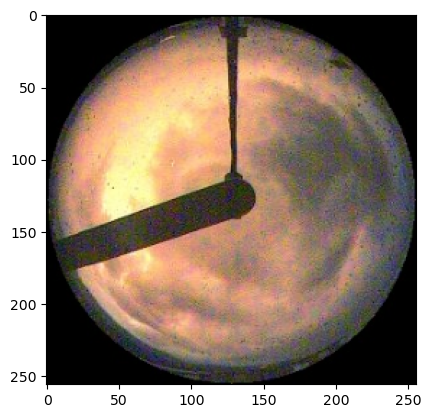

In [374]:
image = cv2.imread(SunSetArray[0,0])
image = cv2.resize(image, (256,256),interpolation = cv2.INTER_LINEAR)
plt.imshow(np.array(image))

In [375]:
# for row in SunSetArray:
#     image = cv2.imread(main_directory+ "/Data/SunSetImg/" +row[0])
#     # image = cv2.resize(image, (8,8),interpolation = cv2.INTER_LINEAR)
#     image_array = np.array(image)
#     row[0] = image_array

In [376]:
from sklearn.model_selection import train_test_split
im_train, im_test, weather_train, weather_test = train_test_split(SunSetArray[:,0], SunSetArray[:,3:], test_size=0.1, random_state=42)
# im_train = im_train/255


In [377]:
im_train

array(['f:\\SunsetPredictor/Data/SunSetImg/20121210162000.raw.jpg',
       'f:\\SunsetPredictor/Data/SunSetImg/20091102165000.raw.jpg',
       'f:\\SunsetPredictor/Data/SunSetImg/20170307174000.raw.jpg', ...,
       'f:\\SunsetPredictor/Data/SunSetImg/20140116164000.raw.jpg',
       'f:\\SunsetPredictor/Data/SunSetImg/20160122165000.raw.jpg',
       'f:\\SunsetPredictor/Data/SunSetImg/20071126163000.raw.jpg'],
      dtype=object)

In [378]:
def load_images(image_paths, imgsize = (256,256)):
    images = []
    for path in image_paths:
        image = cv2.imread(path)
        image = cv2.resize(image, imgsize, interpolation = cv2.INTER_LINEAR )
        images.append(image/255)
    return np.array(images)

In [379]:
weather_train_float = weather_train.astype(np.float32)
weather_train_torch = torch.from_numpy(weather_train_float)
weather_train_torch.shape

torch.Size([4650, 21])

Mini Batch 

In [380]:
def get_minibatch(image_paths, weather_data, batch_size, device, image_resolution=(256,256) ):
    indices = torch.randperm(len(image_paths))[:batch_size]
    images = load_images(image_paths[indices], image_resolution)  # Load images
    x_batch = torch.tensor(images.transpose(0, 3, 1, 2), dtype=torch.float32).to(device)
    y_batch = torch.tensor(weather_data[indices], dtype=torch.float32).to(device)
    return x_batch, y_batch

In [381]:
x1, x2 = get_minibatch(im_train, weather_train_torch, 10,device)

C:\Users\MatthewWilcox\AppData\Local\Temp\ipykernel_8912\3015866930.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(weather_data[indices], dtype=torch.float32).to(device)


In [382]:
print(x1.shape, x2.shape)

torch.Size([10, 3, 256, 256]) torch.Size([10, 21])


In [383]:
def sample_noise(size, device, dim=30):
    return torch.rand((size, dim), device=device)

In [384]:
sample_noise(10,device).shape

torch.Size([10, 30])

Generator

In [385]:
class Generator(nn.Module):
    def __init__(self,latent_dim = 30, context_dim = 21):
        super(Generator,self).__init__()

        self.hidden1_latent = nn.Sequential(nn.Linear(latent_dim,30),  nn.ReLU(),)
        self.hidden1_context = nn.Sequential(nn.Linear(context_dim,30))
        self.hidden2 = nn.Sequential(nn.Linear(60,48), nn.ReLU(), )
        
        self.hidden3 = nn.Sequential(nn.ConvTranspose2d(3,256,1,1,0), nn.ReLU())
        self.out_layer0 = nn.Sequential(nn.Conv2d(256,3, 1, 1, 0, bias=False),nn.Conv2d(3,3, 1, 1, 0, bias=False),nn.Tanh(),)

        self.hidden4 = nn.Sequential(nn.ConvTranspose2d(256,256,4,2,1), nn.ReLU(),)
        self.hidden5 = nn.Sequential(nn.Conv2d(256,256,3,1,1), nn.ReLU(),)
        # First Progression output
        self.out_layer1 = nn.Sequential(nn.Conv2d(256,3, 1, 1, 0, bias=False),nn.Tanh(),)
        #------------------------------------------------------------------------------------------

        self.hidden6 = nn.Sequential(nn.ConvTranspose2d(256,256,4,2,1),nn.ReLU(),)
        self.hidden7 = nn.Sequential(nn.Conv2d(256,256,3,1,1), nn.ReLU(),)
        # Second Progression output
        self.out_layer2 = nn.Sequential(nn.Conv2d(256,3, 1, 1, 0, bias=False),nn.Tanh(),)
        #------------------------------------------------------------------------------------------

        self.hidden8 = nn.Sequential(nn.ConvTranspose2d(256,256,4,2,1), nn.ReLU(),)
        self.hidden9 = nn.Sequential(nn.Conv2d(256,128,3,1,1), nn.ReLU(),)
        # FirsThirdt Progression output
        self.out_layer3 = nn.Sequential(nn.Conv2d(128,3, 1, 1, 0, bias=False),nn.Tanh(),)
        #------------------------------------------------------------------------------------------

        self.hidden10 = nn.Sequential(nn.ConvTranspose2d(128,128,4,2,1), nn.ReLU(),)
        self.hidden11 = nn.Sequential(nn.Conv2d(128,64,3,1,1), nn.ReLU(),)
        # Fourth Progression output
        self.out_layer4 = nn.Sequential(nn.Conv2d(64,3, 1, 1, 0, bias=False),nn.Tanh(),)
        #------------------------------------------------------------------------------------------
        self.hidden12 = nn.Sequential(nn.ConvTranspose2d(64,64,4,2,1), nn.ReLU(),)
        self.hidden13 = nn.Sequential(nn.Conv2d(64,32,3,1,1), nn.ReLU(),)
        # Fithf Progression output
        self.out_layer5 = nn.Sequential(nn.Conv2d(32,3, 1, 1, 0, bias=False),nn.Tanh(),)
        #------------------------------------------------------------------------------------------
        self.hidden14 = nn.Sequential(nn.ConvTranspose2d(32,32,4,2,1),nn.ReLU(),)
        self.hidden15 = nn.Sequential(nn.Conv2d(32,32,3,1,1), nn.ReLU(),)


        # self.hidden2 = nn.Sequential(nn.Linear(1200, 1200), nn.Dropout(p=0.5), nn.ReLU(),)
        self.out_layerFinal = nn.Sequential(nn.ConvTranspose2d(32, 3, 1, 1, 0, bias=False),nn.Tanh(),)

    def forward(self, noise, context, batch, passthrough = 6):
        # print(noise.shape)
        # print(context.shape)
        h = torch.cat((self.hidden1_latent(noise), self.hidden1_context(context)), dim=1)
        # print(h.shape)
        h = self.hidden2(h)
        # print(h.shape)
        h = h.view(batch,3,4,4)
        # print(h.shape)
        h = self.hidden3(h)
        # print(h.shape)
        if passthrough == 0:
            h = self.out_layer0(h)
            # print(h.shape)
            return h
        h = self.hidden4(h)
        # print(h.shape)
        h = self.hidden5(h)
        # print(h.shape)
        if passthrough == 1: 
            h = self.out_layer1(h)
            return h    
        h = self.hidden6(h)
        # print(h.shape)
        h = self.hidden7(h)
        # print(h.shape)
        if passthrough == 2: 
            h = self.out_layer2(h)
            return h
        h = self.hidden8(h)
        # print(h.shape)
        h = self.hidden9(h)
        # print(h.shape)
        if passthrough == 3:
            h = self.out_layer3(h)
            return h
        h = self.hidden10(h)
        # print(h.shape)
        h = self.hidden11(h)
        # print(h.shape)
        if passthrough == 4: 
            h = self.out_layer4(h)
            return h
        h = self.hidden12(h)
        # print(h.shape)
        h = self.hidden13(h)
        # print(h.shape)
        if passthrough == 5: 
            h = self.out_layer5(h)
            return h
        h = self.hidden14(h)
        # print(h.shape)
        h = self.hidden15(h)
        # print(h.shape)

        h = self.out_layerFinal(h)
        return h

In [386]:
class Discriminator(nn.Module):

    def __init__(self, input_dim=256*256*3, context_dim=21):
        super(Discriminator, self).__init__()
        #Image Processing
        
        # 256*256
        self.hidden1 = nn.Sequential(nn.Conv2d(3,32,5,1,2),  nn.LeakyReLU(),)
        self.hidden2 = nn.Sequential(nn.Conv2d(32,32,3,1,1),  nn.LeakyReLU(),)

        #128*128
        self.h128x128 = nn.Sequential(nn.Conv2d(3,64,3,1,1),  nn.LeakyReLU())
        self.hidden3 =  nn.Sequential(nn.Conv2d(32,64,3,2,1),  nn.LeakyReLU(),)
        self.hidden4 =  nn.Sequential(nn.Conv2d(64,64,3,1,1),  nn.LeakyReLU(),)

        #64*64
        self.h64x64 = nn.Sequential(nn.Conv2d(3,128,3,1,1), nn.LeakyReLU())
        self.hidden5 =  nn.Sequential(nn.Conv2d(64,128,3,2,1),  nn.LeakyReLU(),)
        self.hidden6 =  nn.Sequential(nn.Conv2d(128,128,3,1,1),  nn.LeakyReLU(),)

        #32*32
        self.h32x32 = nn.Sequential(nn.Conv2d(3,256,3,1,1),  nn.LeakyReLU())
        self.hidden7 =  nn.Sequential(nn.Conv2d(128,256,3,2,1), nn.LeakyReLU(),)
        self.hidden8 =  nn.Sequential(nn.Conv2d(256,256,3,1,1),  nn.LeakyReLU(),)

        #16*16
        self.h16x16 = nn.Sequential(nn.Conv2d(3,256,3,1,1), nn.LeakyReLU())
        self.hidden9 =  nn.Sequential(nn.Conv2d(256,256,3,2,1),  nn.LeakyReLU(),)
        self.hidden10 =  nn.Sequential(nn.Conv2d(256,256,3,1,1),  nn.LeakyReLU(),)

        #8*8
        self.h8x8 = nn.Sequential(nn.Conv2d(3,256,3,1,1),  nn.LeakyReLU())
        self.hidden11 =  nn.Sequential(nn.Conv2d(256,256,3,2,1), nn.LeakyReLU(),)
        self.hidden12 =  nn.Sequential(nn.Conv2d(256,256,3,1,1), nn.LeakyReLU(),)

        #4*4
        self.h4x4 = nn.Sequential(nn.Conv2d(3,256,3,1,1),  nn.LeakyReLU())
        self.hidden13 =  nn.Sequential(nn.Conv2d(256,256,3,2,1), nn.LeakyReLU(),)
        self.hidden14 =  nn.Sequential(nn.Conv2d(256,256,3,1,1), nn.LeakyReLU(),)

        #Weather Processing

        self.weather1 = nn.Sequential(nn.Linear(21,30),  nn.LeakyReLU(),)

        self.m1 = nn.Sequential(nn.Linear(4126,30),  nn.LeakyReLU())
        self.m2 = nn.Sequential(nn.Linear(30,1),  nn.Sigmoid())
        
    def forward(self, image, weather, batchsize, passthru = 6):

        #256x256
        if passthru >5 :
            # print(image.shape)
            # print(weather.shape)
            h = self.hidden1(image)
            # print(h.shape)
            h= self.hidden2(h)
            # print(h.shape)

            h = self.hidden3(h)
            # print(h.shape)
            h = self.hidden4(h)
            # print(h.shape)

            h = self.hidden5(h)
            # print(h.shape)
            h = self.hidden6(h)
            # print(h.shape)

            h = self.hidden7(h)
            # print(h.shape)
            h = self.hidden8(h)
            # print(h.shape)

            h = self.hidden9(h)
            # print(h.shape)
            h = self.hidden10(h)
            # print(h.shape)
            
            h = self.hidden11(h)
            # print(h.shape)

            h = self.hidden12(h)
            # print(h.shape)

            # print(h.shape)
            h = self.hidden13(h)
            # print(h.shape)
            h = self.hidden14(h)
            # print(h.shape) 


        #128x128
        if passthru == 5:
            h = self.h128x128(image)
            h = self.hidden4(h)
            # print(h.shape)

            h = self.hidden5(h)
            # print(h.shape)
            h = self.hidden6(h)
            # print(h.shape)

            h = self.hidden7(h)
            # print(h.shape)
            h = self.hidden8(h)
            # print(h.shape)

            h = self.hidden9(h)
            # print(h.shape)
            h = self.hidden10(h)
            # print(h.shape)
            
            h = self.hidden11(h)
            # print(h.shape)

            h = self.hidden12(h)
            # print(h.shape)

            # print(h.shape)
            h = self.hidden13(h)
            # print(h.shape)
            h = self.hidden14(h)
            # print(h.shape)

        #64x64
        if passthru == 4:
            h = self.h64x64(image)
            h = self.hidden6(h)
            # print(h.shape)

            h = self.hidden7(h)
            # print(h.shape)
            h = self.hidden8(h)
            # print(h.shape)

            h = self.hidden9(h)
            # print(h.shape)
            h = self.hidden10(h)
            # print(h.shape)
            
            h = self.hidden11(h)
            # print(h.shape)

            h = self.hidden12(h)
            # print(h.shape)

            # print(h.shape)
            h = self.hidden13(h)
            # print(h.shape)
            h = self.hidden14(h)
            # print(h.shape)

        #32x32
        if passthru == 3:
            h = self.h32x32(image)
            h = self.hidden8(h)
            # print(h.shape)

            h = self.hidden9(h)
            # print(h.shape)
            h = self.hidden10(h)
            # print(h.shape)
            
            h = self.hidden11(h)
            # print(h.shape)

            h = self.hidden12(h)
            # print(h.shape)

            # print(h.shape)
            h = self.hidden13(h)
            # print(h.shape)
            h = self.hidden14(h)
            # print(h.shape)


        #16x16
        if passthru == 2:
            h = self.h16x16(image)
            h = self.hidden10(h)
            # print(h.shape)
            
            h = self.hidden11(h)
            # print(h.shape)

            h = self.hidden12(h)
            # print(h.shape)

            # print(h.shape)
            h = self.hidden13(h)
            # print(h.shape)
            h = self.hidden14(h)
            # print(h.shape)

        #8x8
        if passthru == 1:
            h = self.h8x8(image)
            # print(h.shape)
            h = self.hidden12(h)
            # print(h.shape)
            h = self.hidden13(h)
            # print(h.shape)
            h = self.hidden14(h)
            # print(h.shape)


        #4x4
        if passthru == 0:
            h =self.h4x4(image)
            h = self.hidden14(h)
            # print(h.shape)

        # Output: 
        h = h.reshape(batchsize,-1)
        # print(h.shape)

        # Add Weather
        # print(weather.shape)
        w = self.weather1(weather)

        # print(w.shape)

        m = torch.cat((h,w), dim=1)
        # print(m.shape)
        m = self.m1(m)
        # print(m.shape)
        m = self.m2(m)
        # print(m.shape)
        return m

In [387]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

imgbatch, weatherbatch = get_minibatch(im_train, weather_train_torch, 10, device)
print(imgbatch)

C:\Users\MatthewWilcox\AppData\Local\Temp\ipykernel_8912\3015866930.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(weather_data[indices], dtype=torch.float32).to(device)


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

In [388]:
# noise = sample_noise(10,device = 'cuda:0', dim = 30)
# temp = sample_noise(10,device, dim = 21)
# Gen = Generator().to(device)
# x = Gen(noise,temp,10,0)

In [389]:
# input_data = torch.randn(10, 3, 256, 256)

In [390]:
# disc =Discriminator().to(device)
# disc(x, temp,10,0)

In [391]:
# def train(generator, discriminator, generator_optimizer, discriminator_optimizer, schedulers, nb_epochs, k=1,
#           batch_size=100):
#     training_loss = {'generative': [], 'discriminator': []}
#     for epoch in tqdm(range(nb_epochs)):

#         ### Train the disciminator
#         for _ in range(k):
#             # Sample a minibatch of m noise samples
#             z = sample_noise(batch_size, device)
#             # Sample a minibatch of m examples from the data generating distribution
#             x, label = get_minibatch(batch_size, device)

#             # Update the discriminator by ascending its stochastic gradient
#             f_loss = torch.nn.BCELoss()(discriminator(generator(z, label,), label).reshape(batch_size),
#                                         torch.zeros(batch_size, device=device))
#             r_loss = torch.nn.BCELoss()(discriminator(x, label).reshape(batch_size),
#                                         torch.ones(batch_size, device=device))
#             loss = (r_loss + f_loss) / 2
#             discriminator_optimizer.zero_grad()
#             loss.backward()
#             discriminator_optimizer.step()
#             training_loss['discriminator'].append(loss.item())

#         ### Train the generator
#         # Sample a minibatch of m noise samples
#         z = sample_noise(batch_size, device)
#         _, label = get_minibatch(batch_size, device)
#         # Update the generator by descending its stochastic gradient
#         loss = torch.nn.BCELoss()(discriminator(generator(z, label), label).reshape(batch_size),
#                                   torch.ones(batch_size, device=device))
#         generator_optimizer.zero_grad()
#         loss.backward()
#         generator_optimizer.step()
#         training_loss['generative'].append(loss.item())

#         for scheduler in schedulers:
#             scheduler.step()

#     return training_loss

In [510]:
def train(generator, discriminator, generator_optimizer, discriminator_optimizer, schedulers, weather_train, image_train, device, epochs, k=1,G=1, batch_size = 1, progressions = 6):
    training_loss = {'generative': [], 'discriminator': []}
    progression_size = {0:(4,4), 1:(8,8), 2:(16,16), 3:(32,32), 4:(64,64), 5:(128,128), 6:(256,256)}

    for prog in range(0,progressions +1):
        # print("Prog", prog)
        for epoch in tqdm(range(epochs)):
            # print("Epoch", epoch)
            for _ in range(k):
                # Add our Batch Randomness
                noise = sample_noise(batch_size, device)
                #Batch Images and weather
                imgbatch, weatherbatch = get_minibatch(image_train, weather_train, batch_size, device, progression_size[6])
                false_loss = torch.nn.BCELoss()(discriminator( generator(noise, weatherbatch, batch_size, prog), weatherbatch, batch_size, prog).reshape(batch_size),
                                        torch.zeros(batch_size, device=device))
                real_loss = torch.nn.BCELoss()(discriminator(imgbatch, weatherbatch, batch_size, prog).reshape(batch_size),
                                        torch.zeros(batch_size, device=device))
                loss = (real_loss +false_loss)/2
                discriminator_optimizer.zero_grad()
                loss.backward()
                discriminator_optimizer.step()
            training_loss['discriminator'].append(loss.item())
                # print("Disc Loss", loss.item())
            for _ in range(G):
                z = sample_noise(batch_size, device)
                _ , weatherGenbatch = get_minibatch(image_train, weather_train, batch_size, device, progression_size[6])
                loss = torch.nn.BCELoss()(discriminator(generator(z,weatherGenbatch, batch_size, prog),weatherGenbatch, batch_size, prog).reshape(batch_size),
                                            torch.zeros(batch_size, device=device))
                generator_optimizer.zero_grad()
                loss.backward()
                generator_optimizer.step()
                # print("Gen Loss", loss.item())
            training_loss['generative'].append(loss.item())

            for scheduler in schedulers:
                scheduler.step
                
    return training_loss

                


In [512]:
if __name__ == "__main__":

    device = 'cuda:0'
    discriminator = Discriminator().to(device)
    generator = Generator().to(device)
    optimizer_d = optim.Adam(discriminator.parameters(),lr=.0002, betas=(0.5, 0.999))
    optimizer_g = optim.Adam(generator.parameters(), lr = .0002, betas=(0.5, 0.999))
    schedulers = [torch.optim.lr_scheduler.ExponentialLR(optimizer_d, 1 / 1.00004),
                  torch.optim.lr_scheduler.ExponentialLR(optimizer_g, 1 / 1.00004)]

    loss = train(generator, discriminator, optimizer_g, optimizer_d, schedulers, weather_train_torch, im_train, device, epochs = 1, k = 1, G = 3, batch_size=128, progressions=2)


  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\MatthewWilcox\AppData\Local\Temp\ipykernel_8912\3015866930.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(weather_data[indices], dtype=torch.float32).to(device)
  0%|          | 0/1 [00:03<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 8.00 GiB. GPU 

In [444]:
# df = pd.DataFrame(loss)

In [445]:
# import matplotlib.pyplot as plt
# df.plot(kind='line')
# plt.ylim(0,.3)
# plt.show

In [457]:
weather_train_torch[3]

tensor([-7.4833e+00,  1.4800e+01,  3.5000e+00,  7.3400e+01,  7.8000e+00,
         0.0000e+00,  0.0000e+00,  8.5000e+00,  6.0000e+01,  1.0234e+03,
         6.8000e+00,  9.4900e+01,  5.9000e-01,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00])

In [458]:
z = sample_noise(1, device)
z

tensor([[0.1365, 0.2833, 0.2587, 0.2224, 0.5617, 0.2099, 0.2623, 0.7424, 0.3583,
         0.0167, 0.9493, 0.2423, 0.1236, 0.7579, 0.6486, 0.0533, 0.8611, 0.9490,
         0.1826, 0.8090, 0.9999, 0.9618, 0.8349, 0.1198, 0.9802, 0.8493, 0.8936,
         0.8727, 0.6338, 0.4415]], device='cuda:0')

In [501]:
def GenImage(weather_data, imageNum=0):
    z = sample_noise(1, device)
    test_weather = weather_data[imageNum].unsqueeze(0)
    x = generator(z, test_weather.to(device),1,1)
    tempx =x.permute(0, 2, 3, 1).reshape(8,8, 3)
    tempx2 = tempx.cpu().detach().numpy()
    return tempx2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

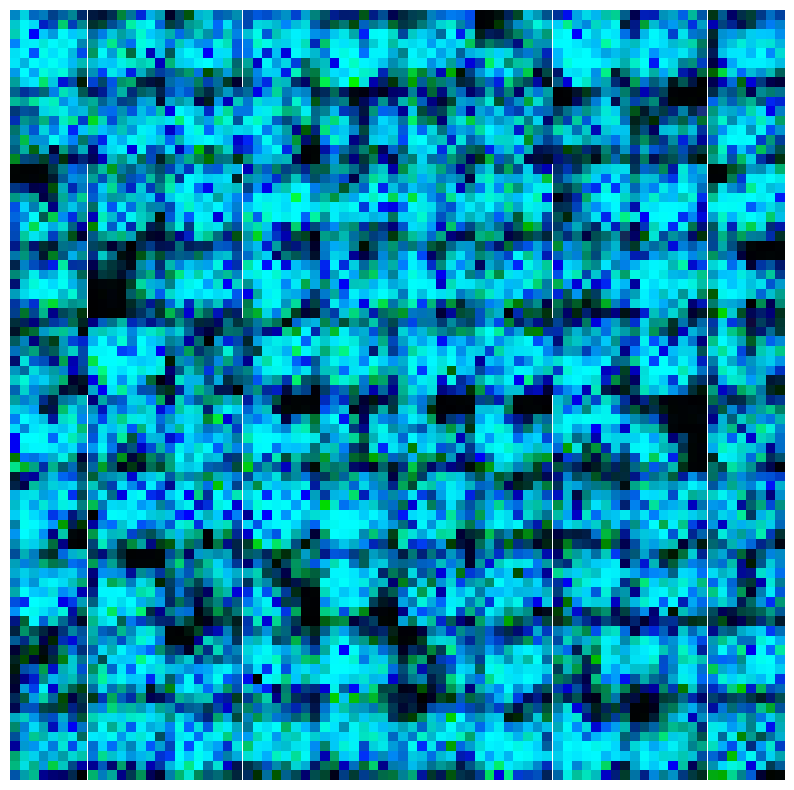

In [502]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        indexI = np.random.randint(0,len(weather_train_float))
        gen_image = GenImage(weather_train_torch, indexI)
        gen_image = cv2.cvtColor(gen_image, cv2.COLOR_BGR2RGB)
        axes[i,j].imshow(gen_image)
        axes[i,j].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()     

In [503]:
x = generator(z, test_weather.to(device),1,0)

In [504]:
x.shape

torch.Size([1, 3, 4, 4])

In [505]:
tempx =x.permute(0, 2, 3, 1).reshape(4,4, 3)

In [506]:
test_weather = weather_train_torch[0].unsqueeze(0)

In [507]:
x = generator(z, test_weather.to(device),1,2)
tempx =x.permute(0, 2, 3, 1).reshape(16,16, 3)
tempx2 = tempx.cpu().detach().numpy()
tempx2 = cv2.cvtColor(tempx2, cv2.COLOR_BGR2RGB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


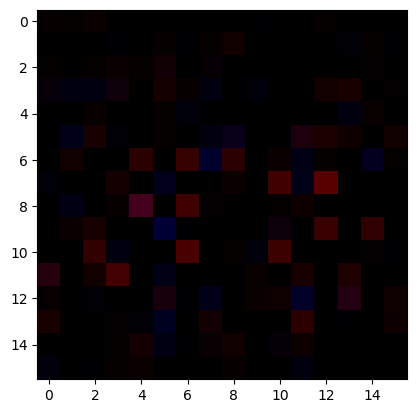

In [508]:
plt.imshow(tempx2)

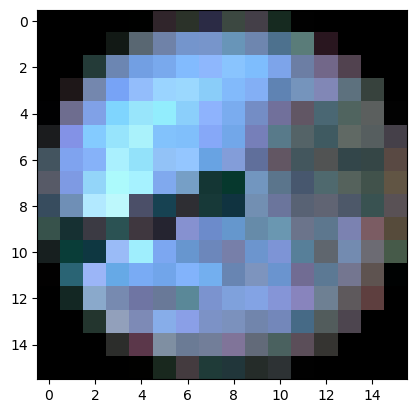

In [509]:
image = cv2.imread(SunSetArray[0,0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
image = cv2.resize(image, (16,16))
plt.imshow(np.array(image))